# Picking branch effects apart to make a model

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = True

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.api import Logit
import statsmodels as sm
from statsmodels.stats.proportion import multinomial_proportions_confint
from progressbar import ProgressBar
import lifelines

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp, token_eq
from analysis.transformations import gaps
from analysis import settings

sb.set()
config = GistsConfiguration.get_solo()
nlp = get_nlp()

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



## 2 Setup

We need a few helper functions first

In [4]:
def gapless(sequence, idx):
    if token_eq(sequence[idx], settings.ALIGNMENT_GAP_CHAR):
        raise ValueError("index {} is a gap in sequence {}"
                         .format(idx, sequence))
    return idx - int(np.sum([token_eq(el, settings.ALIGNMENT_GAP_CHAR)
                             for el in sequence[:idx]]))

def set_order_array(ids):
    return np.array(list(sorted(set(ids))), dtype=int)


def chunk_indices_with_children_exc(deep_alignments):
    for dal in deep_alignments:
        seq1 = dal['seq1']
        seq2 = dal['seq2']
        subalignments = dal['subalignments']
        
        # Compute this level's app/dis/apprpl/disrpl/stb ids
        base_app_ids = []
        base_dis_ids = []
        base_rpl_pairs = []
        base_stb_pairs = []
        for i, (tok1, tok2) in enumerate(zip(seq1, seq2)):
            if token_eq(tok1, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok2, settings.ALIGNMENT_GAP_CHAR)
                base_app_ids.append(gapless(seq2, i))
            elif token_eq(tok2, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok1, settings.ALIGNMENT_GAP_CHAR)
                base_dis_ids.append(gapless(seq1, i))
            elif tok1.lemma == tok2.lemma or tok1.orth == tok2.orth:
                base_stb_pairs.append((gapless(seq1, i), gapless(seq2, i), False))
            else:
                base_rpl_pairs.append((gapless(seq1, i), gapless(seq2, i), False))

        # Check we saw all the parent ids exactly once
        parent_ids = (base_dis_ids +
                      [pid for pid, _, _ in base_rpl_pairs] +
                      [pid for pid, _, _ in base_stb_pairs])
        assert len(set(parent_ids)) == max(parent_ids) + 1
        
        # See if that's all the work we have to do
        if len(subalignments) == 0:
            yield (set_order_array(base_app_ids),
                   set_order_array(base_dis_ids),
                   set_order_array(base_rpl_pairs),
                   set_order_array(base_stb_pairs))
            # Don't recurse more since there are no subalignments.
            # Instead move on to the next deep_alignment.
            break
        
        # Nope, we must combine this level with all the combinations of subalignments
        for subalignment in subalignments:
            
            if len(subalignment) == 0:
                # This subalignment is the base alignment (which was as good as
                # or better than other subalignments)
                yield (set_order_array(base_app_ids),
                       set_order_array(base_dis_ids),
                       set_order_array(base_rpl_pairs),
                       set_order_array(base_stb_pairs))
                continue
            
            # For this mapping, get the list of exchanges and the list of chunk_indices iterators
            # from each exchange
            excs, excs_chunk_indices_iter = zip(*[(exc, chunk_indices_with_children_exc(exc_dals))
                                                  for exc, exc_dals in subalignment.items()])
            # Loop through the product of paths from each exchange
            for excs_chunk_indices_tuple in itertools.product(*excs_chunk_indices_iter):
                app_ids = set(base_app_ids)
                dis_ids = set(base_dis_ids)
                rpl_pairs = set(base_rpl_pairs)
                stb_pairs = set(base_stb_pairs)
                
                for (((start1, stop1), (start2, stop2)),
                     (exc_app_ids, exc_dis_ids, exc_rpl_pairs, exc_stb_pairs)) \
                        in zip(excs, excs_chunk_indices_tuple):
                
                    gapless2_start1 = gapless(seq2, start1)
                    gapless2_stop1 = gapless(seq2, stop1 - 1) + 1
                    gapless1_start2 = gapless(seq1, start2)
                    gapless1_stop2 = gapless(seq1, stop2 - 1) + 1
                    
                    app_ids.difference_update(range(gapless2_start1, gapless2_stop1))
                    dis_ids.difference_update(range(gapless1_start2, gapless1_stop2))
                    
                    app_ids.update(gapless2_start1 + exc_app_ids)
                    dis_ids.update(gapless1_start2 + exc_dis_ids)
                    rpl_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid, True)
                                      for pid, cid, _ in exc_rpl_pairs])
                    stb_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid, True)
                                      for pid, cid, _ in exc_stb_pairs])
                
                yield (set_order_array(app_ids),
                       set_order_array(dis_ids),
                       set_order_array(rpl_pairs),
                       set_order_array(stb_pairs))

def contiguous_chunks(ids):
    """Get the list of contiguous chunks in `ids`.
    
    A contiguous chunk here is a suite of ids that follow each other.
    If `ids` is empty, returns an empty list.
    
    """
    
    assert len(set(ids)) == len(ids)
    ids = sorted(ids)
    if len(ids) == 0:
        return []
    
    chunks = []
    chunk = [ids[0]]
    
    for id in ids[1:]:
        if id == max(chunk) + 1:
            chunk.append(id)
        else:
            chunks.append(chunk)
            chunk = [id]
    
    chunks.append(chunk)
    return chunks

In [5]:
def branch_sentences(sentence, with_root=False, with_leaf=True):
    # Walk back up to the head of the branch
    head = sentence.head
    
    if with_root:
        yield head.parent
    
    current = head
    while current.children.kept.count() > 0 and current.depth < config.target_branch_depth:
        if current.children.kept.count() > 1:
            raise ValueError("More than one (kept) children for sentence {}"
                             .format(current.id))
        yield current
        current = current.children.kept.first()
    
    if with_leaf:
        # Yield the final leaf
        yield current

In [6]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [7]:
def plot_int_dist(x, scale=None, ax=None,
                  plot_kws={'marker': 'o', 'lw': 0}, hist_kws={},
                  **kws):
    assert scale in [None, 'ylog', 'loglog'], scale
    
    bins = np.linspace(x.min() -.5, x.max() + .5, int(x.max() - x.min() + 2))
    middles = (bins[1:] + bins[:-1]) / 2
    hist, _ = np.histogram(x, bins=bins, **hist_kws)
    
    if ax is None:
        ax = plt.gca()
    ax.plot(middles, hist, **plot_kws, **kws)
    if scale == 'ylog':
        ax.set_yscale('log')
    if scale == 'loglog':
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.locator_params(subs='all')
    return ax

Now build the master DataFrame that we plot below

In [8]:
data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            rpl_outexc = [pair for pair in rpl_pairs if not pair[2]]
            rpl_inexc = [pair for pair in rpl_pairs if pair[2]]
            stb_outexc = [pair for pair in stb_pairs if not pair[2]]
            stb_inexc = [pair for pair in stb_pairs if pair[2]]
            
            data.append({
                'tree_id': tree.id,
                'branch_id': head.id,
                'parent_id': parent.id,
                'child_id': child.id,

                'parent_depth': parent.depth,
                'parent_length': len(parent.tokens),

                'ins_count': len(app_ids),
                'del_count': len(dis_ids),
                'stb_outexc_count': len(stb_outexc),
                'rpl_outexc_count': len(rpl_outexc),
                'stb_inexc_count': len(stb_inexc),
                'rpl_inexc_count': len(rpl_inexc),
                
                'ins_chunk_count': len(contiguous_chunks(app_ids)),
                'del_chunk_count': len(contiguous_chunks(dis_ids)),
                'exc_chunk_count': len(contiguous_chunks(
                    [p[0] for p in itertools.chain(stb_inexc, rpl_inexc)])),
                'stbrpl_outexc_chunk_count': len(contiguous_chunks(
                    [p[0] for p in itertools.chain(stb_outexc, rpl_outexc)])),
                'stb_outexc_chunk_count': len(contiguous_chunks([p[0] for p in stb_outexc])),
                'rpl_outexc_chunk_count': len(contiguous_chunks([p[0] for p in rpl_outexc])),
                'stb_inexc_chunk_count': len(contiguous_chunks([p[0] for p in stb_inexc])),
                'rpl_inexc_chunk_count': len(contiguous_chunks([p[0] for p in rpl_inexc])),
            })

data = pd.DataFrame(data)

100% (50 of 50) |#########################| Elapsed Time: 0:04:09 Time: 0:04:09


## 3 Counts

Prepare some data values

In [9]:
data['exc_count'] = data.stb_inexc_count + data.rpl_inexc_count
data['stbrpl_outexc_count'] = data.stb_outexc_count + data.rpl_outexc_count
data['stb_outexc_count_rel'] = data.stb_outexc_count / data.parent_length
data['del_count_rel'] = data.del_count / data.parent_length

has_transformation = ((data.del_count > 0)
                      | (data.ins_count > 0)
                      | (data.rpl_outexc_count > 0)
                      | (data.exc_count > 0))
unique_transformation = (has_transformation
                         & (((data.del_count == 0) & (data.ins_count == 0) & (data.rpl_outexc_count == 0))
                            | ((data.del_count == 0) & (data.ins_count == 0) & (data.exc_count == 0))
                            | ((data.del_count == 0) & (data.rpl_outexc_count == 0) & (data.exc_count == 0))
                            | ((data.ins_count == 0) & (data.rpl_outexc_count == 0) & (data.exc_count == 0))))

data['has_del'] = data.del_count > 0
data['has_ins'] = data.ins_count > 0
data['has_rpl_outexc'] = data.rpl_outexc_count > 0
data['has_exc'] = data.exc_count > 0

columns_count = ['del_count',
                 'ins_count',
                 'rpl_outexc_count',
                 'exc_count',
                 'stb_outexc_count']
columns_count_rel = ['del_count_rel',
                     'stb_outexc_count_rel']
columns_chunk = ['del_chunk_count',
                 'ins_chunk_count',
                 'rpl_outexc_chunk_count',
                 'exc_chunk_count',
                 'stb_outexc_chunk_count']
max_count = data[columns_count].max().max()
max_count_rel = data[columns_count_rel].max().max()
max_chunk = data[columns_chunk].max().max()

We're going to ignore replacements inside exchanges, so that our ontology of possible transformations is: deletion, insertion, replacement, exchange (with or without inner replacement, which we ignore), stability.

Just to make sure, the total number of *transformations with replacements inside an exchange* is:

In [10]:
(data.rpl_inexc_count > 0).sum()

37

Totalling this many words replaced:

In [11]:
data.rpl_inexc_count.sum()

45

vs. the number of transformations with replacements out of an exchange:

In [12]:
(data.rpl_outexc_count > 0).sum()

1316

### Counts

Contingency table for deletion and insertion only:

In [13]:
data['del_count']\
    .groupby([(data.del_count > 0), (data.ins_count > 0)])\
    .count()\
    .rename_axis(['Deletion', 'Insertion'])\
    .unstack(0)


Deletion,False,True
Insertion,,
False,1796,593
True,160,912


Without deletion, insertion has very low probability. With insertion, deletion has very high probability. One way to see this is to look at deletions first, and then look at the distribution of insertions. Below we compare the distribution of insertions without and with deletion:

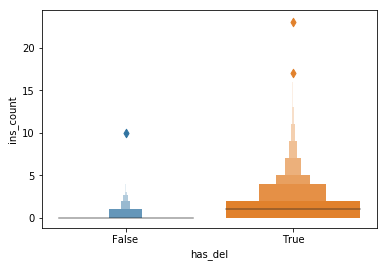

In [15]:
sb.lvplot(y='ins_count', x='has_del', data=data)

Contingency table for all our transformations:

In [16]:
data['del_count']\
    .groupby([(data.del_count > 0), (data.ins_count > 0), (data.rpl_outexc_count > 0), (data.exc_count > 0)])\
    .count()\
    .rename_axis(['Deletion', 'Insertion', 'Replacement', 'Exchange'])\
    .unstack([0, 2])


Deletion           False       True       
Replacement        False True  False True 
Insertion Exchange                        
False     False     1367   399   267   282
          True        14    16    22    22
True      False       62    87   350   427
          True         5     6    58    77

## 4 Distributions of counts for each transformation

Now a look at the distributions of counts of each transformation:

In [17]:
def plot_columns(data, columns, filtering=None, **kwargs):
    if filtering is None:
        filtering = lambda df, c: np.ones_like(df.index, dtype=bool)
    fig, axes = plt.subplots(len(columns), 1, figsize=(8, 3*len(columns)), sharex=True)
    for col, ax in zip(columns, axes):
        plot_int_dist(data[filtering(data, col)][col], ax=ax, **kwargs)
        ax.set_title(col)

## 5 Correlations of counts

The number of deletions depends a lot on the size of the sentence, see the regression:

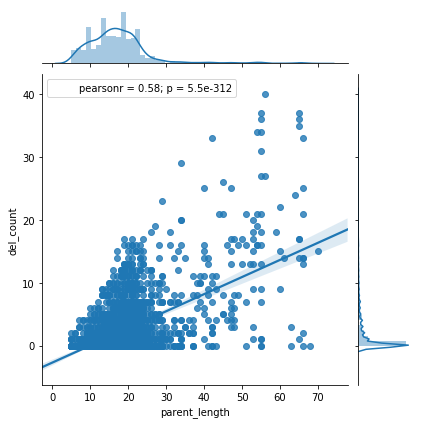

In [26]:
sb.jointplot(x='parent_length', y='del_count', data=data, kind='reg')

And residuals of the regression:

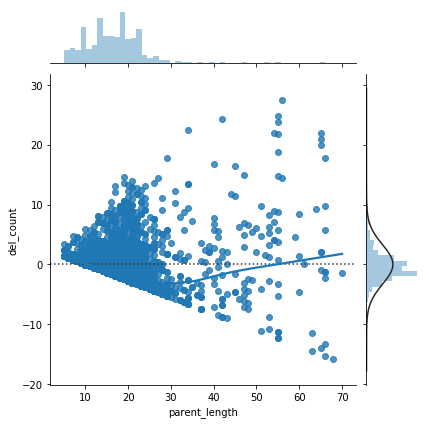

In [27]:
sb.jointplot(x='parent_length', y='del_count', data=data, kind='resid', lowess=True)

The number of insertions also relates to the number of deletions. See the regression with non-zero deletion:

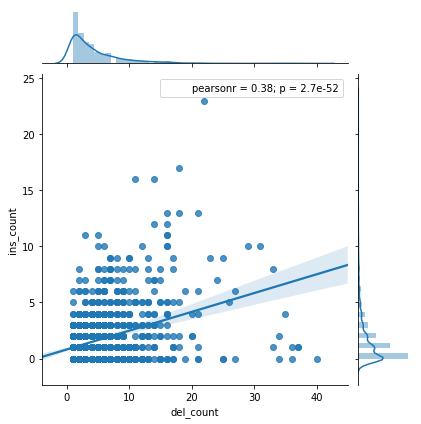

In [28]:
sb.jointplot(x='del_count', y='ins_count', data=data[(data.del_count > 0)], kind='reg')

And the regression with both non-zero deletion and non-zero insertion:

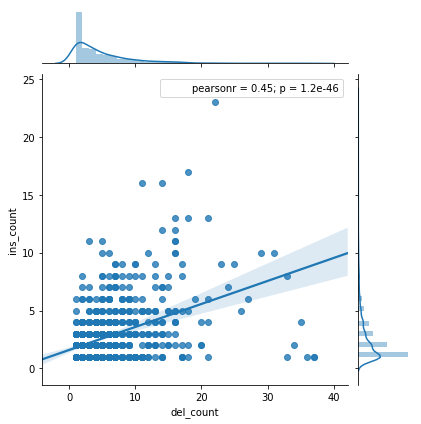

In [29]:
sb.jointplot(x='del_count', y='ins_count', data=data[(data.ins_count > 0) & (data.del_count > 0)], kind='reg')

## 6 Increase/decrease in sentence size

It looks like when there are more insertions than deletions (i.e. the length of the sentence increases), a shortening happens quickly after that. Here we try to test that.

In [30]:
increase = (data.ins_count > data.del_count)
follow_increase = pd.Series(index=data.index, data=False)
for branch_id, depth in zip(data[increase].branch_id, data[increase].parent_depth):
    follow_increase = follow_increase | ((data.branch_id == branch_id) & (data.parent_depth == depth+1))

In [31]:
data['increase'] = increase
data['follow_increase'] = follow_increase

Here's the distribution of deletions right after an increase in length, vs. not:

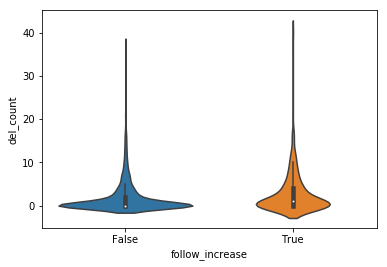

In [32]:
sb.violinplot(x='follow_increase', y='del_count', data=data)

And here's the regression of the size of length increase vs. the size of the deletion that follows it:

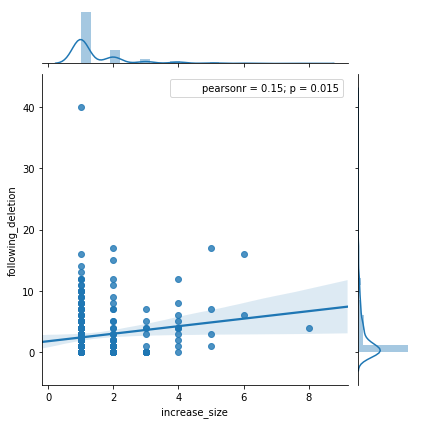

In [33]:
increase_pairs = []
for i, (branch_id, depth) in enumerate(zip(data[follow_increase].branch_id,
                                           data[follow_increase].parent_depth)):
    increase_pairs.append({
        'increase_size': (data[(data.branch_id == branch_id)
                               & (data.parent_depth == depth-1)].ins_count.iloc[0]
                          - data[(data.branch_id == branch_id)
                                 & (data.parent_depth == depth-1)].del_count.iloc[0]),
        'following_deletion': data[(data.branch_id == branch_id)
                                   & (data.parent_depth == depth)].del_count.iloc[0]
    })
increase_pairs = pd.DataFrame(increase_pairs)
sb.jointplot(x='increase_size', y='following_deletion', data=increase_pairs, kind='reg')

Not a strong correlation.

## 8 Position in sentence

Prepare the data

In [8]:
data_position = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            for tipe, ref_sentence, ids in \
                    [('del', parent, dis_ids),
                     ('ins', child, app_ids),
                     ('rpl_parent', parent, [p[0] for p in rpl_pairs]),
                     ('rpl_child', child, [p[1] for p in rpl_pairs]),
                     ('stb_parent', parent, [p[0] for p in stb_pairs]),
                     ('stb_child', child, [p[1] for p in stb_pairs])]:
                left_indices = set(range(len(ref_sentence.tokens)))
                for chunk in contiguous_chunks(ids):
                    for i, index in enumerate(chunk):
                        left_indices.remove(index)
                        ref_start_quantile, ref_stop_quantile = \
                            quantile_interval(np.arange(len(ref_sentence.tokens)), index)
                        data_position.append({
                            'tree_id': tree.id,
                            'branch_id': head.id,
                            'parent_id': parent.id,
                            'child_id': child.id,

                            'parent_depth': parent.depth,
                            'parent_length': len(parent.tokens),
                            'ref_sentence_length': len(ref_sentence.tokens),

                            'tipe': tipe,
                            'target': True,
                            'position': index,
                            'position_rel': index / (len(ref_sentence.tokens) - 1),
                            'position_start_quantile': ref_start_quantile,
                            'position_stop_quantile': ref_stop_quantile,
                        })
                for index in left_indices:
                    ref_start_quantile, ref_stop_quantile = \
                        quantile_interval(np.arange(len(ref_sentence.tokens)), index)
                    data_position.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),
                        'ref_sentence_length': len(ref_sentence.tokens),

                        'tipe': tipe,
                        'target': False,
                        'position': index,
                        'position_rel': index / (len(ref_sentence.tokens) - 1),
                        'position_start_quantile': ref_start_quantile,
                        'position_stop_quantile': ref_stop_quantile,
                    })

data_position = pd.DataFrame(data_position)
columns_position = ['del', 'ins', 'rpl_parent', 'rpl_child', 'stb_parent', 'stb_child']

100% (50 of 50) |#########################| Elapsed Time: 0:04:08 Time: 0:04:08


In [9]:
tipe_to_tex = {
    'del': r'$\mathcal{D}$',
    'ins': r'$\mathcal{I}$',
    'rpl_parent': r'$\mathcal{R}_p$',
    'rpl_child': r'$\mathcal{R}_c$'
}
columns_position_r = [tipe_to_tex.get(t, t) for t in columns_position]
data_position['tipe_r'] = data_position.tipe.apply(lambda t: tipe_to_tex.get(t, t))

In [10]:
blue, green, red, purple, yellow, cyan = sb.color_palette()

In [11]:
sentence_lengths = np.array([len(s.parent.tokens)
                             for s in Sentence.objects.experiment.kept.filter(parent__isnull=False)
                             if s.depth <= config.target_branch_depth])

In [12]:
long_sentence = None
_, sentence_bins = pd.qcut(sentence_lengths, 5, retbins=True)
sentence_bins = sentence_bins.astype(int)
sentence_bins

array([ 5, 11, 15, 18, 22, 70])

### Preliminary: probability of a transformation for a given parent length

In [13]:
tr_prob = data_position.groupby(['child_id', 'tipe_r', 'tipe', 'parent_length'])\
    .target\
    .aggregate(lambda x: bool(x.sum() > 0))\
    .reset_index()

Now the distributions of positions of all words in transformations

In [14]:
data_position['weight_all'] = 1
data_position['weight_target'] = data_position.target.astype(np.float)

data_position.weight_all = data_position\
    .groupby(['child_id', 'tipe'])\
    .weight_all\
    .transform(lambda x: x / x.sum())

data_position.weight_target = data_position\
    .groupby(['child_id', 'tipe'])\
    .weight_target\
    .transform(lambda x: x / ((data_position.loc[x.index].target * x).sum() or 1))
assert np.isnan(data_position.weight_target).sum() == 0

In [15]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    bin_count = kwargs.get('bins', 5)
    ax = kwargs.get('ax', plt.gca())
    
    # Compute bin heights
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    step = 1 / bin_count
    for i in range(bin_count):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data['position_stop_quantile'])
                          - bound(limits, data['position_start_quantile']))
                         / (data['position_stop_quantile'] - data['position_start_quantile']))
        heights[i] = (contributions * data.weight_target * data.target).sum()
        h0s[i] = (contributions * data.weight_all).sum()
    total = sum(heights)
    total_h0 = sum(h0s)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total_h0 / h0s[:, np.newaxis])
    
    # Plot them.
    x = np.linspace(0, 1, bin_count)
    ax.plot(x, (heights / total) / (h0s / total_h0),
            color=color)
    ax.fill_between(x, cis[:, 0], cis[:, 1],
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.plot(x, np.ones_like(h0s), '--',
            color=sb.desaturate(color, 0.2))
    ax.set_xlim(x[0], x[-1])
    ax.set_yscale('log')

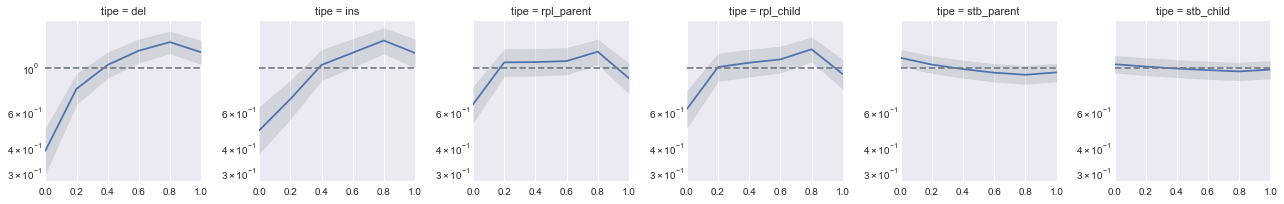

In [16]:
g = sb.FacetGrid(data=data_position, dropna=False,
                 col='tipe', col_order=columns_position,
                 size=3, sharex=True, sharey=True)
g.map_dataframe(plot_sentencequantile_susties, bins=6)

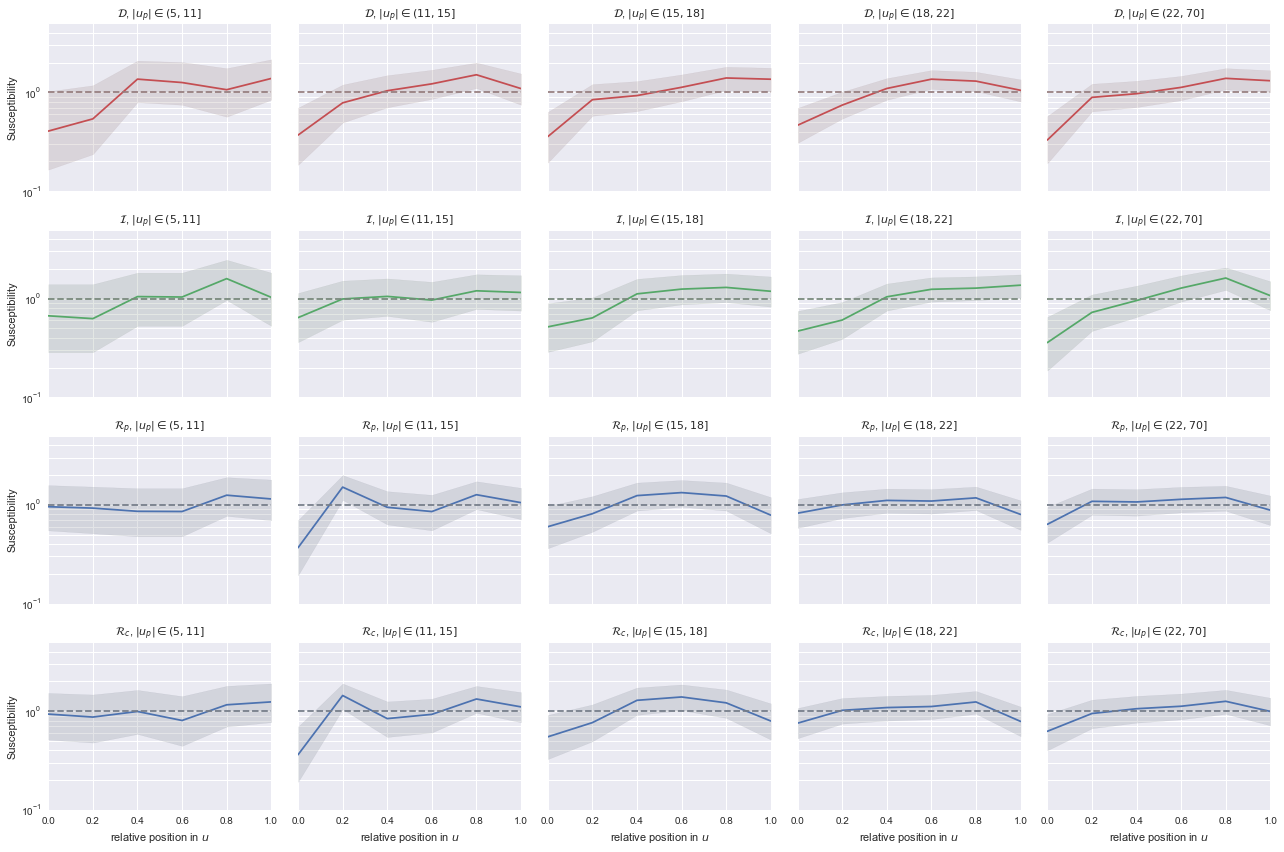

In [17]:
data_position['parent_length_bin'] = pd.cut(data_position.parent_length, sentence_bins)

g = sb.FacetGrid(data=data_position,#[data_position.parent_length <= long_sentence],
                 row='tipe_r', row_order=columns_position_r[:4],
                 hue='tipe_r', hue_order=columns_position_r[:4],
                 palette=[red, green, blue, blue],
                 col='parent_length_bin',
                 size=3, aspect=1.2,
                 sharex=True, sharey=True)
g.map_dataframe(plot_sentencequantile_susties, bins=6)
g.set_titles('{row_name}, $|u_p| \\in {col_name}$')
g.set_ylabels('Susceptibility')
g.set_xlabels('relative position in $u$')
g.set(ylim=(0.1, 5))
for ax in g.axes.ravel():
    ax.locator_params(subs='all')
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
g.fig.tight_layout()

### Paper figures

In [18]:
tr_prob = sm.tools.add_constant(tr_prob)

for tipe in columns_position[:3]:
    print('===')
    print(tipe)
    print('===')
    logit = Logit(tr_prob[tr_prob.tipe == tipe].target,
                  tr_prob[tr_prob.tipe == tipe][['const', 'parent_length']])
    res = logit.fit()
    print(res.summary())
    print('Inflexion =', - res.params[0] / res.params[1])
    print()

===
del
===
Optimization terminated successfully.
         Current function value: 0.593063
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 3461
Model:                          Logit   Df Residuals:                     3459
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Aug 2017   Pseudo R-squ.:                  0.1338
Time:                        04:17:40   Log-Likelihood:                -2052.6
converged:                       True   LL-Null:                       -2369.5
                                        LLR p-value:                7.274e-140
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.6826      0.124    -21.564      0.000      -2.926      -2.439
parent_l

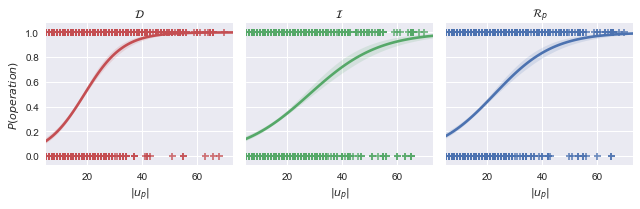

In [37]:
g = sb.FacetGrid(data=tr_prob,
                 col='tipe_r', col_order=columns_position_r[:3],
                 hue='tipe_r', hue_order=columns_position_r[:3],
                 palette=[red, green, blue],
                 sharex=True, sharey=True)
g.map(sb.regplot, 'parent_length', 'target', logistic=True, marker='+')
g.set_titles('{col_name}')
g.set_xlabels(r'$|u_p|$')
g.set_ylabels(r'$P(operation)$')
g.set(xlim=(5, None))
#g.add_legend(title='Operation')
if SAVE_FIGURES:
    g.fig.savefig(FIG.format('p-ops_parent-length_logistic'), dpi=300, bbox='tight')

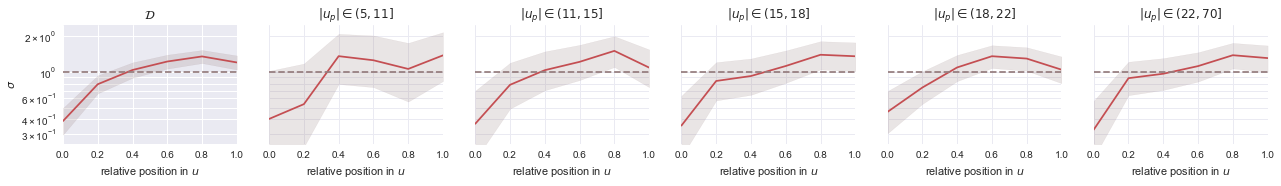

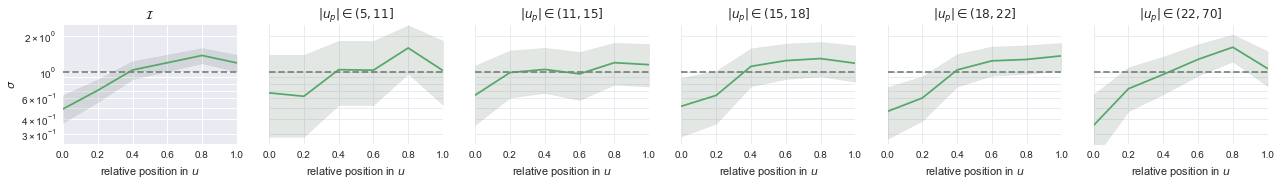

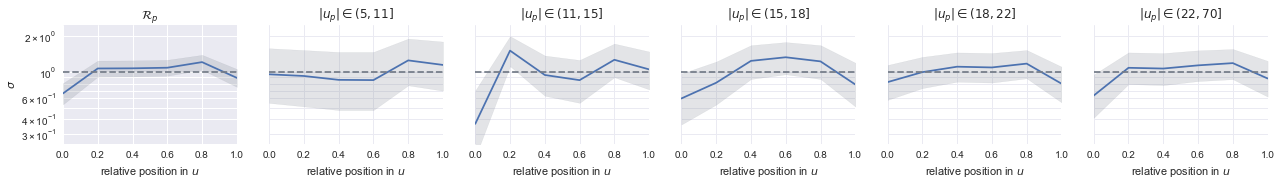

In [54]:
for tipe, tipe_r, color in zip(columns_position[:3], columns_position_r[:3], [red, green, blue]):
    fig, axes = plt.subplots(1, 6, figsize=(18, 2.75), sharex=True, sharey=True)
    
    plot_sentencequantile_susties(data=data_position[(data_position.tipe_r == tipe_r)],
                                  bins=6, color=color, ax=axes[0])
    axes[0].set_ylim(.25, 2.5)
    axes[0].set_title(tipe_r)
    axes[0].set_xlabel('relative position in $u$')
    axes[0].set_ylabel(r'$\sigma$')
    
    for i, sbin in enumerate(sorted(set(data_position.parent_length_bin).difference([np.nan]))):
        plot_sentencequantile_susties(data=data_position[#(data_position.parent_length <= long_sentence) &
                                                         (data_position.tipe_r == tipe_r)
                                                         & (data_position.parent_length_bin == sbin)],
                                      bins=6, color=color, ax=axes[i+1])
        axes[i+1].set_title('$|u_p| \\in {}$'.format(sbin))
        axes[i+1].set_xlabel('relative position in $u$')
        axes[i+1].set_facecolor('white')
        axes[i+1].grid(color='#EAEAF2')
    
    for ax in axes:
        ax.locator_params(subs='all')
        ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    fig.tight_layout()
    
    if SAVE_FIGURES:
        fig.savefig(FIG.format('susceptibility-{}_position_parent-length'.format(tipe)),
                    dpi=300, bbox_inches='tight')

## 9 Distributions of word-operations/#chunks/chunk-sizes

Prepare the data

In [21]:
data_size = []
dal_counts = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            ciwces = list(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            dal_counts.append(len(ciwces))
            # See below for the justification of this line: we take only the first deep alignment
            # for the following statistics, as only 53 sentences have more than one deep alignment
            # and creating distributions averaged over deep alignments is really complicated.
            app_ids, dis_ids, rpl_pairs, stb_pairs = ciwces[0]
            
            for tipe, ref_sentence, ids in \
                [('del', parent, dis_ids),
                 ('ins', child, app_ids),
                 ('rpl_parent', parent, [p[0] for p in rpl_pairs]),
                 ('rpl_child', child, [p[1] for p in rpl_pairs]),
                 ('stb_parent', parent, [p[0] for p in stb_pairs]),
                 ('stb_child', child, [p[1] for p in stb_pairs])]:
                chunks = contiguous_chunks(ids)
                for chunk in chunks:
                    data_size.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),
                        'ref_sentence_length': len(ref_sentence.tokens),

                        'tipe': tipe,
                        'chunk_size': len(chunk),
                        'chunk_start': chunk[0] / len(ref_sentence.tokens),
                        'chunk_stop': (chunk[-1] + 1) / len(ref_sentence.tokens),
                        'chunk_count': len(chunks)
                    })

dal_counts = np.array(dal_counts)
columns_size = ['del', 'ins', 'rpl_parent', 'rpl_child', 'stb_parent', 'stb_child']
data_size = pd.DataFrame(data_size)

100% (50 of 50) |#########################| Elapsed Time: 0:00:25 Time: 0:00:25


Histogram of deep-alignment counts:

(array([  3.40800000e+03,   4.60000000e+01,   4.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 6 Patch objects>)

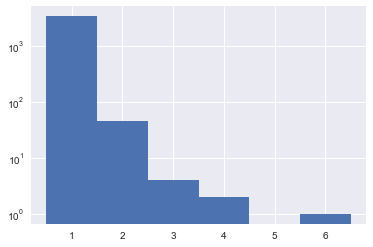

In [22]:
plt.hist(dal_counts, bins=np.arange(dal_counts.max() + 1) + .5, log=True)

In [23]:
columns_size_r = [tipe_to_tex.get(t, t) for t in columns_size]
data_size['tipe_r'] = data_size.tipe.apply(lambda t: tipe_to_tex.get(t, t))

In [24]:
data_size['weight'] = 1 / data_size.chunk_count
#data_size['weight'] = data_size.groupby(['branch_id', 'tipe'])\
#    .weight\
#    .transform(lambda x: x / x.sum())

In [25]:
word_chunk_counts = data_size\
    .groupby(['tipe', 'child_id', 'parent_length'])\
    .chunk_size\
    .aggregate(['sum', 'size'])\
    .rename(columns={'sum': 'word_count', 'size': 'chunk_count'})\
    .reset_index()
word_chunk_counts['parent_length_bin'] = pd.cut(word_chunk_counts.parent_length, sentence_bins)

### Word operations

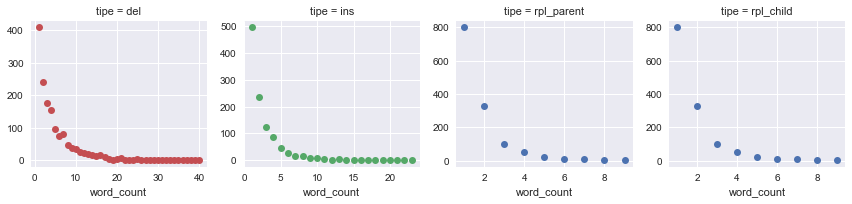

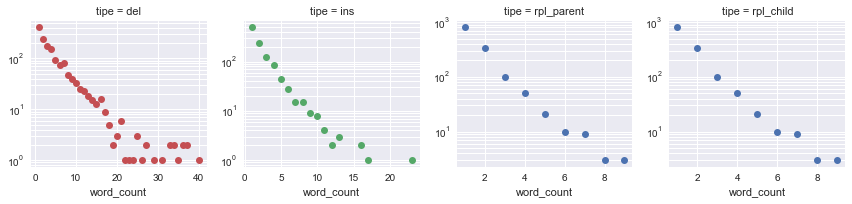

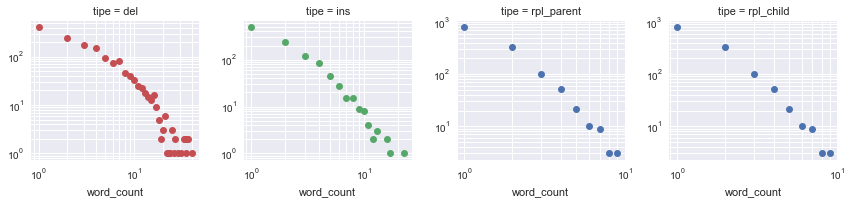

In [26]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 #size=5,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'word_count')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 #size=5,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'word_count', scale='ylog')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 #size=5,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'word_count', scale='loglog');

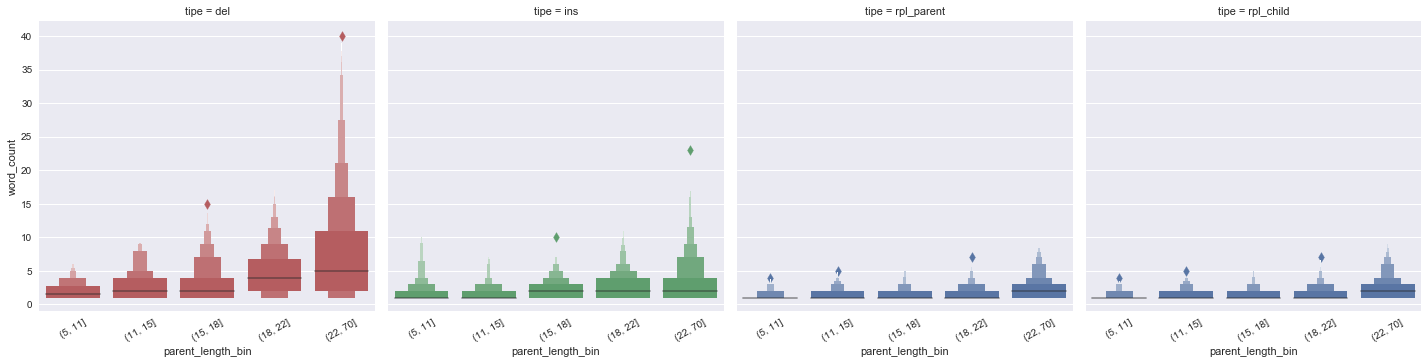

In [27]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 size=5)
g.map(sb.lvplot, 'parent_length_bin', 'word_count')
g.set_xticklabels(rotation=30)

### Chunk counts

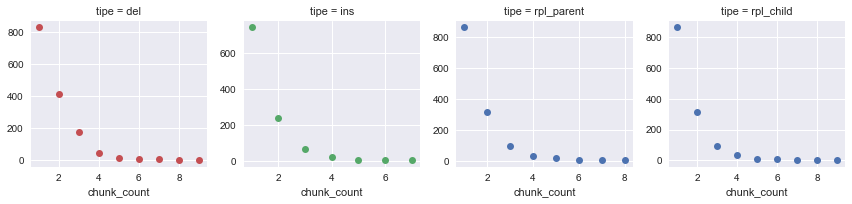

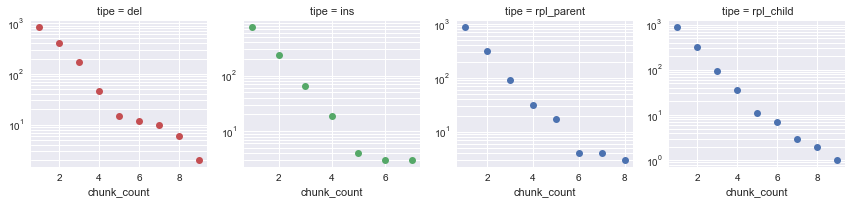

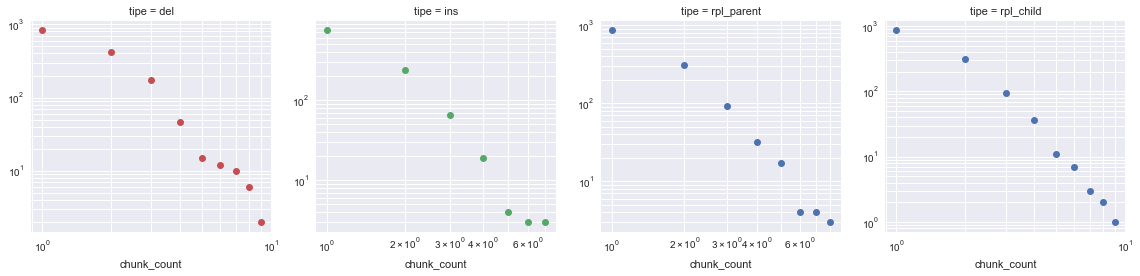

In [28]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'chunk_count')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'chunk_count', scale='ylog')

g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 size=4,
                 sharex=False, sharey=False)
g.map(plot_int_dist, 'chunk_count', scale='loglog')
g.set_xticklabels()

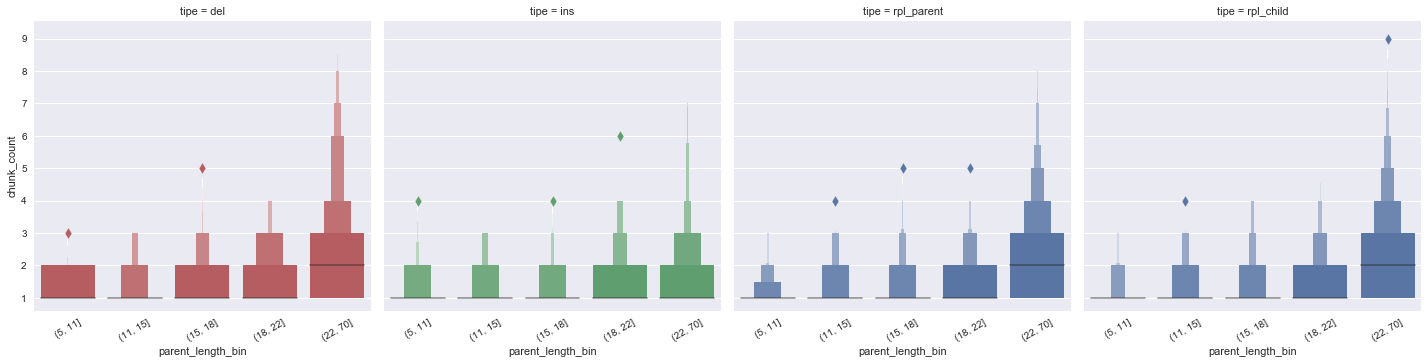

In [29]:
g = sb.FacetGrid(word_chunk_counts,
                 col='tipe', col_order=columns_size[:4],
                 hue='tipe',
                 palette=[red, green, blue, blue],
                 size=5)
g.map(sb.lvplot, 'parent_length_bin', 'chunk_count')
g.set_xticklabels(rotation=30)

### Chunk sizes

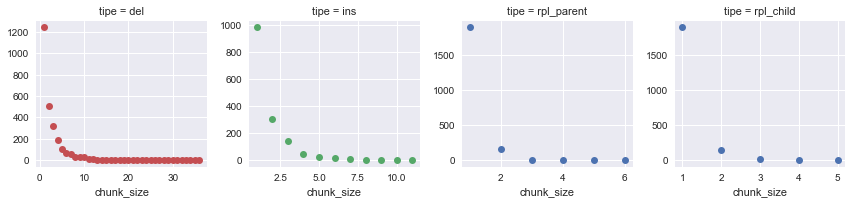

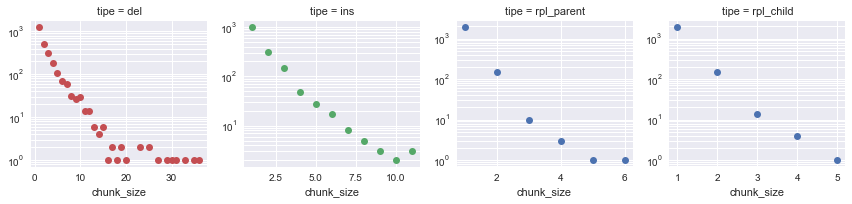

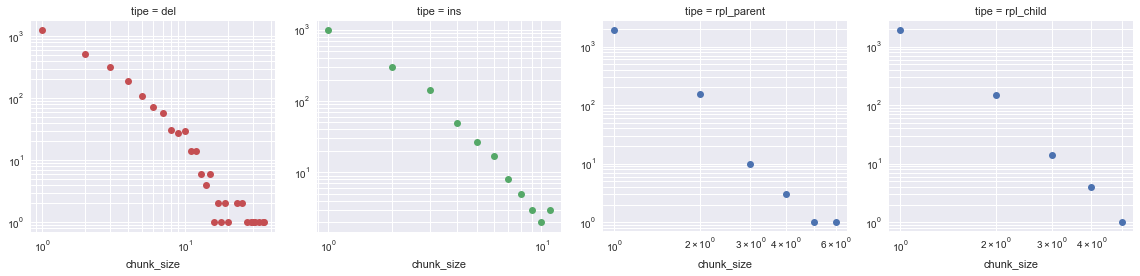

In [30]:
g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size[:4],
                 hue='tipe', hue_order=columns_size[:4],
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False, size=3)
g.map(plot_int_dist, 'chunk_size')

g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size[:4],
                 hue='tipe', hue_order=columns_size[:4],
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False, size=3)
g.map(plot_int_dist, 'chunk_size', scale='ylog')

g = sb.FacetGrid(data_size, col='tipe', col_order=columns_size[:4],
                 hue='tipe', hue_order=columns_size[:4],
                 palette=[red, green, blue, blue],
                 sharex=False, sharey=False, size=4)
g.map(plot_int_dist, 'chunk_size', scale='loglog')
g.set_xticklabels()

In [55]:
def weighted_std(values, weights, ddof=0):
    avg = np.average(values, weights=weights)
    variance, n = np.average((values - avg)**2, weights=weights, returned=True)
    return np.sqrt(variance * n / (n - ddof))

def plot_size_positions(**kwargs):
    data = kwargs['data']
    ax = kwargs.get('ax', plt.gca())
    color = kwargs.get('color', 'blue')
    bins = kwargs.get('bins', 10)
    tipe_r = data.iloc[0].tipe_r
    
    # Compute bin heights
    heights = np.zeros(bins)
    cis = np.zeros(bins)
    step = 1 / bins
    for i in range(bins):
        limits = [i * step, (i + 1) * step]
        contributions = (bound(limits, data['chunk_stop']) - bound(limits, data['chunk_start'])) / step
        # The height of a bin is the average size of chunks which have words in it.
        # But if a chunk touches a bin only partially, it contributes only that portion
        # to the height of the bin (which is what 'contributions' measures).
        # We further weigh the sizes by pre-computed weights which embody what entities we 
        # consider independent (trees or transformations).
        heights[i] = ((data.weight * contributions * data.chunk_size).sum()
                      / (data.weight * contributions).sum())
        wn = (data.weight * contributions).sum()
        wstd = weighted_std(data.chunk_size, weights=data.weight * contributions, ddof=1)
        cis[i] = wstd * stats.t.ppf(1 - .05/2, wn - 1) / np.sqrt(wn)
    total = sum(heights)
    print(tipe_r)
    print(heights)
    
    # Plot them.
    x = np.linspace(0, 1, bins)
    ax.plot(x, heights, color=color, label=tipe_r)
    ax.fill_between(x, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.set_xlim(x[0], x[-1])

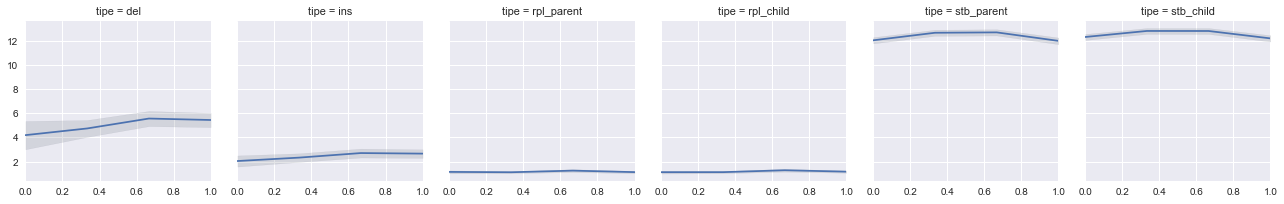

In [32]:
g = sb.FacetGrid(data=data_size, col='tipe', col_order=columns_size,
                 size=3,
                 sharex=True, sharey=True)
g.map_dataframe(plot_size_positions, bins=4)

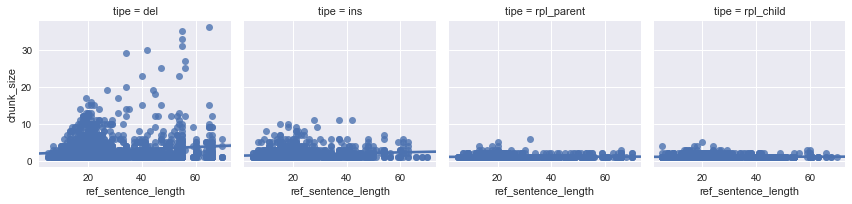

In [33]:
g = sb.FacetGrid(data=data_size, col='tipe', col_order=columns_size[:4],
                 size=3,
                 sharex=True, sharey=True)
g.map(sb.regplot, 'ref_sentence_length', 'chunk_size')

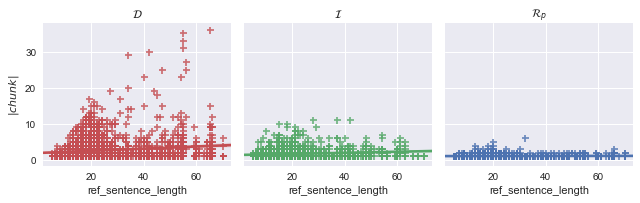

In [34]:
g = sb.FacetGrid(data=data_size,
                 col='tipe_r', col_order=columns_size_r[:3],
                 hue='tipe_r', hue_order=columns_size_r[:3],
                 palette=[red, green, blue],
                 size=3,
                 sharex=True, sharey=True)
g.map(sb.regplot, 'ref_sentence_length', 'chunk_size', marker='+')
g.set_titles('{col_name}')
g.set_ylabels(r'$|chunk|$')

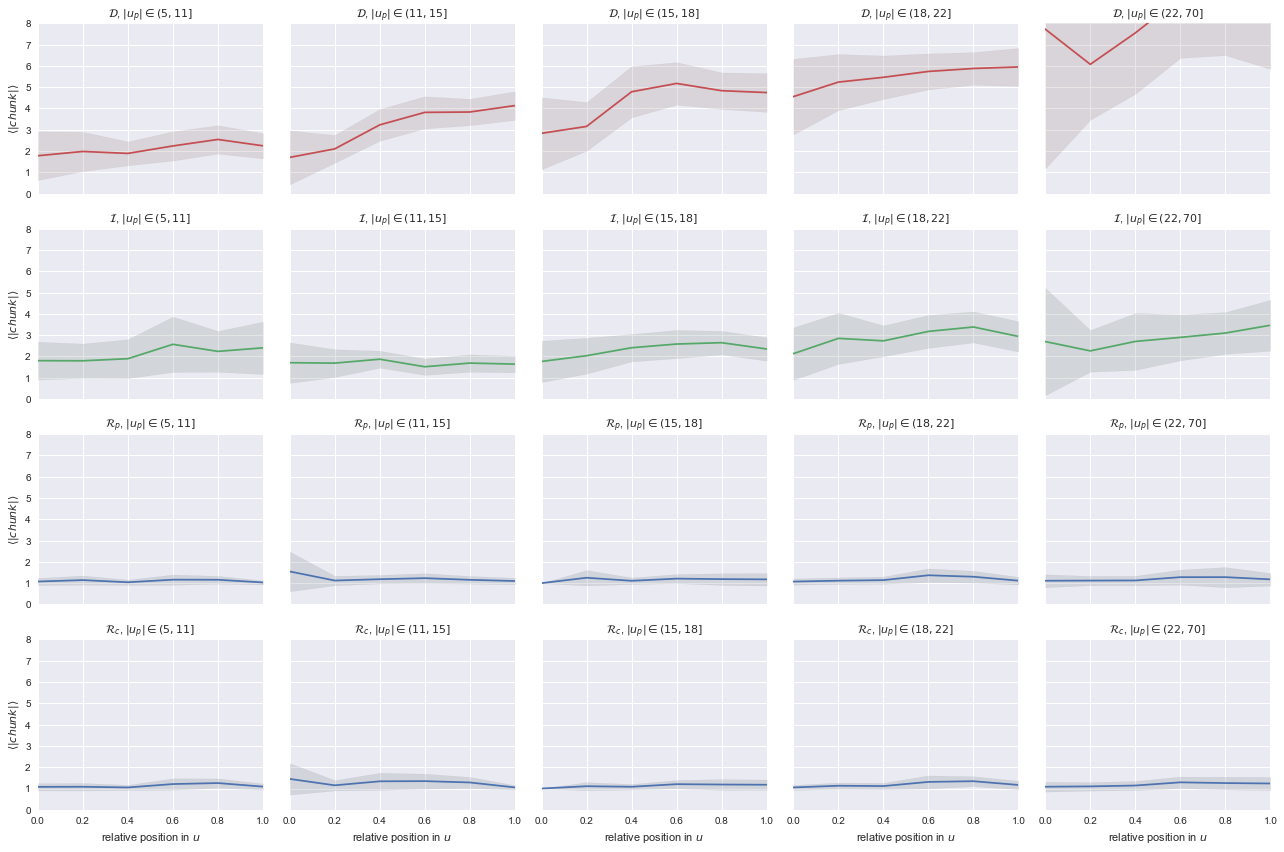

In [35]:
data_size['parent_length_bin'] = pd.cut(data_size.parent_length, sentence_bins)

g = sb.FacetGrid(data=data_size,#[data_size.parent_length <= long_sentence],
                 row='tipe_r', row_order=columns_size_r[:4],
                 hue='tipe_r', hue_order=columns_size_r[:4],
                 palette=[red, green, blue, blue],
                 col='parent_length_bin',
                 size=3, aspect=1.2,
                 sharex=True, sharey=True)
g.map_dataframe(plot_size_positions, bins=6)
g.set_titles('{row_name}, $|u_p| \\in {col_name}$')
g.set_ylabels(r'$\left< |chunk| \right>$')
g.set_xlabels('relative position in $u$')
g.set(ylim=(0, 8))
g.fig.tight_layout()

### Paper figures

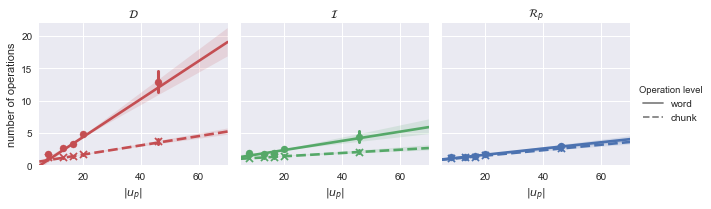

In [41]:
word_chunk_counts['tipe_r'] = word_chunk_counts.tipe.apply(lambda t: tipe_to_tex.get(t, t))
g = sb.FacetGrid(word_chunk_counts[word_chunk_counts.tipe_r.isin(columns_size_r[:3])],
                 col='tipe_r', col_order=columns_size_r[:3],
                 hue='tipe_r',
                 palette=[red, green, blue, blue],
                 size=3,
                 xlim=(word_chunk_counts.parent_length.min(), word_chunk_counts.parent_length.max()),
                 ylim=(0, 22))
g.axes[0, 0].plot([], [], color='grey', label='word')
g.axes[0, 0].plot([], [], color='grey', linestyle='dashed', label='chunk')
g.map(sb.regplot, 'parent_length', 'word_count', x_bins=(sentence_bins[1:] + sentence_bins[:-1]) / 2)
g.map(sb.regplot, 'parent_length', 'chunk_count', x_bins=(sentence_bins[1:] + sentence_bins[:-1]) / 2,
      line_kws={'linestyle': 'dashed'}, marker='x')
g.set_titles('{col_name}')
g.set_ylabels('number of operations')
g.set_xlabels('$|u_p|$')
g.add_legend(title='Operation level', label_order=['word', 'chunk'])
if SAVE_FIGURES:
    g.fig.savefig(FIG.format('chunk-size_parent-length'), dpi=300, bbox='tight')

In [46]:
for tipe in columns_size[:3]:
    print(tipe)
    res = stats.linregress(word_chunk_counts[word_chunk_counts.tipe == tipe].parent_length,
                           word_chunk_counts[word_chunk_counts.tipe == tipe].word_count)
    print(res)
    print('1 / slope =', 1 / res.slope)
    print()

del
LinregressResult(slope=0.29401006318587319, intercept=-1.5216506667117722, rvalue=0.58247201219438238, pvalue=1.9670175739222475e-137, stderr=0.010583235443806844)
1 / slope = 3.40124412465

ins
LinregressResult(slope=0.071046496955218238, intercept=0.94377764698430378, rvalue=0.33310894583026524, pvalue=3.4186831233602884e-29, stderr=0.0061478710773446004)
1 / slope = 14.0752893226

rpl_parent
LinregressResult(slope=0.048161716417391337, intercept=0.68300044681746908, rvalue=0.43450010029656133, pvalue=2.5755016311251134e-62, stderr=0.0027405843369561951)
1 / slope = 20.7633795966



$\mathcal{D}$
[ 4.16751178  4.30144637  4.90141179  5.54944001  5.56561691  5.40948787]
$\mathcal{I}$
[ 1.97736936  2.1843992   2.37640122  2.67483908  2.76423271  2.61102794]
$\mathcal{R}_p$
[ 1.13616942  1.1419679   1.12176324  1.25483461  1.21328409  1.11128564]
$\mathcal{D}$
[ 1.7811833   1.98130498  1.88945315  2.24002123  2.54540418  2.24737639]
$\mathcal{I}$
[ 1.80195865  1.79581521  1.89403226  2.56939855  2.23827911  2.4044284 ]
$\mathcal{R}_p$
[ 1.07469805  1.14294298  1.0395362   1.16231029  1.15843621  1.03091583]
$\mathcal{D}$
[ 1.70236307  2.1022928   3.22978876  3.81677711  3.83414893  4.1350522 ]
$\mathcal{I}$
[ 1.70636391  1.68645382  1.87071187  1.51641962  1.68843923  1.64028179]
$\mathcal{R}_p$
[ 1.54753099  1.12189933  1.1841941   1.23278606  1.15553662  1.09911495]
$\mathcal{D}$
[ 2.83339195  3.15790523  4.78458796  5.17632975  4.83554805  4.74804281]
$\mathcal{I}$
[ 1.76573737  2.03444869  2.40956545  2.58307166  2.64677411  2.35064776]
$\mathcal{R}_p$
[ 1.      

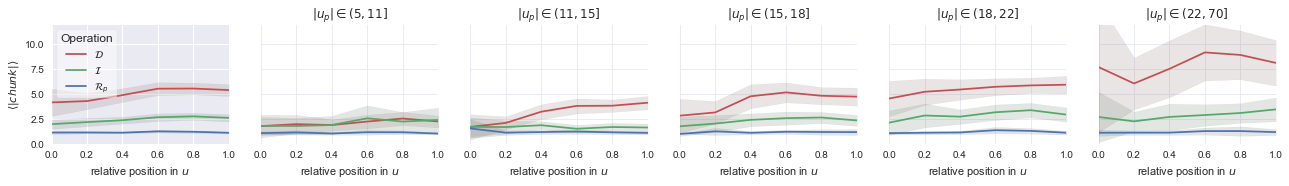

In [56]:
fig, axes = plt.subplots(1, 6, figsize=(18, 2.75), sharex=True, sharey=True)

for tipe_r, color in zip(columns_size_r[:3], [red, green, blue]):
    plot_size_positions(data=data_size[(data_size.tipe_r == tipe_r)],
                        color=color, bins=6, ax=axes[0])
axes[0].set_xlabel('relative position in $u$')
axes[0].set_ylabel(r'$\left< |chunk| \right>$')
legend = axes[0].legend(title='Operation', loc='upper left', frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(.5)

for i, sbin in enumerate(sorted(set(data_size.parent_length_bin).difference([np.nan]))):
    for tipe_r, color in zip(columns_size_r[:3], [red, green, blue]):
        plot_size_positions(data=data_size[#(data_size.parent_length <= long_sentence) &
                                           (data_size.tipe_r == tipe_r)
                                           & (data_size.parent_length_bin == sbin)],
                            color=color, bins=6, ax=axes[i+1])
    axes[i+1].set_xlabel('relative position in $u$')
    axes[i+1].set_title(r'$|u_p| \in {}$'.format(sbin))
    axes[i+1].set_facecolor('white')
    axes[i+1].grid(color='#EAEAF2')

axes[0].set_ylim(0, 12)
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(FIG.format('chunk-size_position_parent-length'), dpi=300, bbox='tight')

## 10 Burstiness of it all

First a few helpers

In [192]:
def burstiness(inter_events):
    s = inter_events.std()
    m = inter_events.mean()
    return (s - m) / (s + m)

In [193]:
def intervals(ids):
    last_end = None
    for chunk in contiguous_chunks(ids):
        if last_end is not None:
            yield chunk[0] - last_end - 1
        last_end = chunk[-1]
        yield from (len(chunk) - 1) * [0]

In [194]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [195]:
def powerset_nonempty(iterable):
    return itertools.islice(powerset(iterable), 1, None)

### 10.1 Bursts of transformations in a sentence

FIXME: burstiness is computed as if trees were the independent items, whereas the rest is computed with sentences as the independent items

Prepare the data

In [196]:
data_size_intervals = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    
    for head in tree.root.children.kept:
        
        for parent, child in pairwise(branch_sentences(head, with_root=True, with_leaf=True)):
            
            app_ids, dis_ids, rpl_pairs, stb_pairs = \
                next(chunk_indices_with_children_exc(parent.align_deep_lemmas(child)))
            
            rpl_outexc = [pair for pair in rpl_pairs if not pair[2]]
            rpl_inexc = [pair for pair in rpl_pairs if pair[2]]
            stb_outexc = [pair for pair in stb_pairs if not pair[2]]
            stb_inexc = [pair for pair in stb_pairs if pair[2]]
            
            for tipe_ids in itertools.chain(
                    powerset_nonempty([('del', dis_ids),
                                       ('rpl_parent',
                                        [p[0] for p in itertools.chain(rpl_outexc, rpl_inexc)]),
                                       ('exc_parent',
                                        [p[0] for p in itertools.chain(stb_inexc, rpl_inexc)])]),
                    powerset_nonempty([('ins', app_ids),
                                       ('rpl_child',
                                        [p[1] for p in itertools.chain(rpl_outexc, rpl_inexc)]),
                                       ('exc_child',
                                        [p[1] for p in itertools.chain(stb_inexc, rpl_inexc)])])):
                tipe, ids = zip(*tipe_ids)
                # itertools.chain(*ids) yields some duplicates whenever a replacement appears
                # in an exchange. So we remove the duplicates with set().
                ids = set(itertools.chain(*ids))
                tipe = '+'.join(tipe)
                for interval in intervals(ids):
                    data_size_intervals.append({
                        'tree_id': tree.id,
                        'branch_id': head.id,
                        'parent_id': parent.id,
                        'child_id': child.id,

                        'parent_depth': parent.depth,
                        'parent_length': len(parent.tokens),

                        'tipe': tipe,
                        'interval_size': interval
                    })

data_size_intervals = pd.DataFrame(data_size_intervals)

100% (50 of 50) |#########################| Elapsed Time: 0:00:26 Time: 0:00:26


Compute burstinesses for all combinations of transformations, with zero-valued intervals

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.



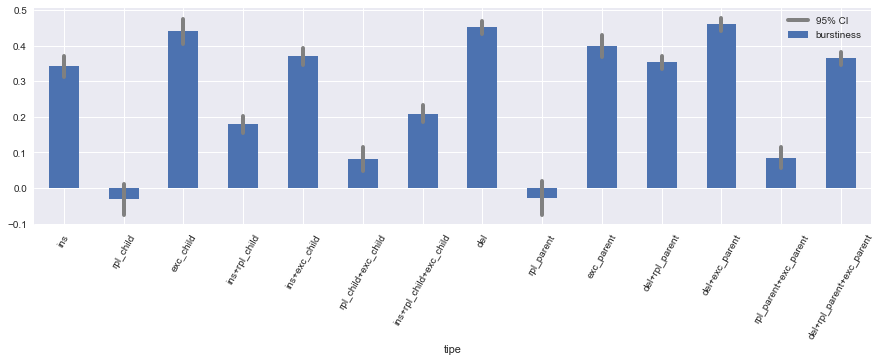

In [14]:
order = ['+'.join(t) for t in itertools.chain(powerset_nonempty(['ins', 'rpl_child', 'exc_child']),
                                              powerset_nonempty(['del', 'rpl_parent', 'exc_parent']))]
word_burstiness = pd.DataFrame({
    'burstiness': data_size_intervals
         .groupby(['tree_id', 'tipe'])
         .interval_size
         .aggregate(burstiness)
})

word_burstiness['ci'] = word_burstiness.burstiness
word_burstiness = word_burstiness\
    .groupby(level=1)\
    .aggregate({
        'burstiness': 'mean',
        'ci': lambda x: x.std(ddof=1) * stats.t.ppf(1 - .05/2, x.size - 1) / np.sqrt(x.size)
    }).loc[order]

ax = word_burstiness.burstiness.plot(kind='bar', figsize=(15, 4), rot=60)
for i, row in enumerate(order):
    b = word_burstiness.loc[row].burstiness
    ci = word_burstiness.loc[row].ci
    ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
            label='95% CI' if i == 0 else None)
ax.legend()

In [23]:
def plot_burstinesses(burstiness, ops, colors, labels, ylabel, title,
                      ax=None, xlim=None, labelsrot=0):
    if ax is None:
        ax = plt.gca()
    ax.bar(range(len(ops)), burstiness.burstiness.loc[ops], color=colors)
    ax.set_xticks(range(len(ops)))
    ax.set_xticklabels(labels, rotation=labelsrot)
    for i, row in enumerate(ops):
        b = burstiness.loc[row].burstiness
        ci = burstiness.loc[row].ci
        ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
                label='95% CI' if i == 0 else None)
    ax.set_xlim(xlim)
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color='grey', linestyle='--', lw=2)
    ax.legend()
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

blue, green, red, purple, yellow, cyan = sb.color_palette()

Separated by parent and child utterance, then the combination of all

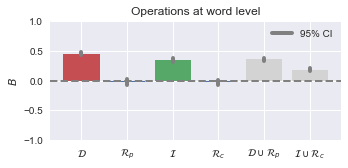

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
plot_burstinesses(word_burstiness,
                  ['del', 'rpl_parent', 'ins', 'rpl_child', 'del+rpl_parent', 'ins+rpl_child'],
                  [red, blue, green, blue, 'lightgrey', 'lightgrey'],
                  ['$\mathcal{D}$', '$\mathcal{R}_p$', '$\mathcal{I}$', '$\mathcal{R}_c$',
                   '$\mathcal{D} \cup \mathcal{R}_p$', '$\mathcal{I} \cup \mathcal{R}_c$'],
                  '$B$', 'Operations at word level', ax=ax)
ax.set_ylim(-1, 1)
fig.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG.format('burstiness-words'), dpi=300, bbox='tight')

In [50]:
ax.get_position()

Bbox([[0.15475, 0.18533333333333335], [0.964, 0.8499618055555556]])

In [51]:
.964 - .15475

0.80925

Now without zero-valued intervals, i.e. burstiness of chunks of events

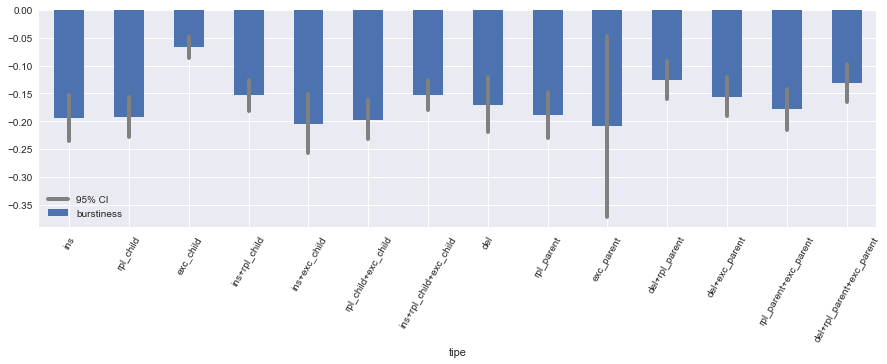

In [16]:
chunk_burstiness = pd.DataFrame({
    'burstiness': data_size_intervals[data_size_intervals.interval_size > 0]
         .groupby(['tree_id', 'tipe'])
         .interval_size
         .aggregate(burstiness)
})

chunk_burstiness['ci'] = chunk_burstiness.burstiness
chunk_burstiness = chunk_burstiness\
    .groupby(level=1)\
    .aggregate({
        'burstiness': 'mean',
        'ci': lambda x: x.std(ddof=1) * stats.t.ppf(1 - .05/2, x.size - 1) / np.sqrt(x.size)
    }).loc[order]

ax = chunk_burstiness.burstiness.plot(kind='bar', figsize=(15, 4), rot=60)
for i, row in enumerate(order):
    b = chunk_burstiness.loc[row].burstiness
    ci = chunk_burstiness.loc[row].ci
    ax.plot([i, i], [b - ci, b + ci], lw=4, color='grey',
            label='95% CI' if i == 0 else None)
ax.legend()

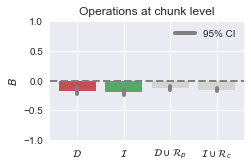

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5 * (1-.809) + 5 * (2/3) * .809, 2.5))
plot_burstinesses(chunk_burstiness,
                  ['del', 'ins', 'del+rpl_parent', 'ins+rpl_child'],
                  [red, green, 'lightgrey', 'lightgrey'],
                  ['$\mathcal{D}$', '$\mathcal{I}$',
                   '$\mathcal{D} \cup \mathcal{R}_p$', '$\mathcal{I} \cup \mathcal{R}_c$'],
                  '$B$', 'Operations at chunk level', ax=ax)
ax.set_ylim(-1, 1)
fig.tight_layout()
if SAVE_FIGURES:
    fig.savefig(FIG.format('burstiness-chunks'), dpi=300, bbox='tight')

So if you compress chunks to a single event, it's not bursty at all.

### 10.2 Bursts of sentence transformations in a branch

Prepare the data

In [55]:
stabilities0 = []
for branch_id in set(data.branch_id):
    child_depths = 1 + data[(data.branch_id == branch_id)
                            & (data.ins_count == 0)
                            & (data.del_count == 0)
                            & (data.exc_count == 0)
                            & (data.rpl_outexc_count == 0)].parent_depth
    for contiguous_stability in contiguous_chunks(child_depths):
        stabilities0.append({
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': len(contiguous_stability),
            # Only account for unobserved end of stabilities due to branch cutoff, not spam
            'observed': max(contiguous_stability) < config.target_branch_depth
        })
    for chunk in contiguous_chunks(set(1 + data[data.branch_id == branch_id].parent_depth)
                                   .difference(child_depths)):
        stabilities0.extend((len(chunk) - 1) * [{
            'tree_id': data[data.branch_id == branch_id].iloc[0].tree_id,
            'branch_id': branch_id,
            'duration': 0,
            'observed': True
        }])

stabilities0 = pd.DataFrame(stabilities0)

Burstiness using all stabilities or observed-only, with or without zero-valued intervals

In [56]:
sentence_burstiness = pd.DataFrame({
    'all': stabilities0
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'observed-only': stabilities0[stabilities0.observed]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'chunk all': stabilities0[stabilities0.duration > 0]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness),
    'chunk observed-only': stabilities0[(stabilities0.duration > 0) & stabilities0.observed]
         .groupby(['tree_id'])
         .duration
         .aggregate(burstiness)
})

for flavour in ['all', 'observed-only', 'chunk all', 'chunk observed-only']:
    avg = sentence_burstiness[flavour].mean()
    print("Sentence burstiness ({}) = {}".format(flavour, avg))
    ci = (sentence_burstiness[flavour].std(ddof=1)
          * stats.t.ppf(1 - .05/2, sentence_burstiness[flavour].size - 1)
          / np.sqrt(sentence_burstiness[flavour].size))
    print("CI ({}) = [{}, {}]".format(flavour, avg - ci, avg + ci))
    print()

Sentence burstiness (all) = 0.250934562713121
CI (all) = [0.2222545814744477, 0.27961454395179425]

Sentence burstiness (observed-only) = 0.3046198469476558
CI (observed-only) = [0.27349617978182633, 0.3357435141134853]

Sentence burstiness (chunk all) = -0.24721291329549802
CI (chunk all) = [-0.2859490581410662, -0.20847676844992982]

Sentence burstiness (chunk observed-only) = -0.3117747223693398
CI (chunk observed-only) = [-0.35043904791229763, -0.27311039682638194]



And note that even for that last flavour, we have quite a few measures:

In [57]:
((stabilities0.duration > 0) & stabilities0.observed).sum()

501

## 12 Modelling

### 12.1 Super-simple per-word model

For each word of the parent sentence, we have the choice between deletion/insertion/replacement.

$$
p(e_n) \propto \begin{cases}
  p_d, & \text{for $e_n$ deletion} \\
  p_i, & \text{for $e_n$ insertion} \\
  p_r, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.2 Per-word + chunkiness

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* with a different probability if the preceding event is of the same type

$$
p(e_n) \propto \begin{cases}
  p_d a_d^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ deletion} \\
  p_i a_i^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ insertion} \\
  p_r a_r^{\delta_{e_{n-1}, e_n}}, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.3 Per-word + chunkiness + position-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability if the preceding event is of the same type
* and all probabilities depend on the position in the sentence

$$
p(e_n) \propto \begin{cases}
  \frac{1}{1 + e^{- a_d^{\delta_{e_{n-1}, e_n}} - \gamma_d - \beta_d n}}, & \text{for $e_n$ deletion} \\
  \frac{1}{1 + e^{- a_i^{\delta_{e_{n-1}, e_n}} - \gamma_i - \beta_i n}}, & \text{for $e_n$ insertion} \\
  \frac{1}{1 + e^{- a_r^{\delta_{e_{n-1}, e_n}} - \gamma_r - \beta_r n}}, & \text{for $e_n$ replacement} \\
  1 - \sum_{e'_n \neq \text{stability}} p(e'_n), & \text{for $e_n$ stability}
\end{cases}
$$

### 12.4 Per-word + chunkiness + position-dependence + sentence length-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability if the preceding event is of the same type
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence

### 12.5 Per-word + event-dependent chunkiness + position-dependence + sentence length-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability depending on the type of the preceding event (i.e. compare to all event types, not only the same one)
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence

### 12.6 Per-word + event-dependent chunkiness + position-dependence + sentence length-dependence + memory

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement,
* with a different probability depending on the type of the preceding event (i.e. compare to all event types, not only the same one)
* all probabilities depend on the position in the sentence
* all probabilities depend on the overall length of the sentence
* for deletion and insertion, the probability depends on the proportion of events of opposite type in a preceding window

### 12.7 Per-word-and-block

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence

### 12.8 Per-word-and-block + position-dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence

### 12.9 Per-word-and-block + position-dependence + sentence-length dependence

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence, but whose variance depends on the overall length of the sentence

### 12.10 Per-word-and-block + position-dependence + sentence-length dependence + memory

For each word of the parent sentence:
* we have the choice between deletion/insertion/replacement
* that choice depends on the position in the sentence
* for deletions and insertions, it also depends on the distance to the closest opposite transformation
* we choose a size for the block we create, according to some distribution whose average does not depend on the position in the sentence, but whose variance depends on the overall length of the sentence
* for deletions and insertions, the size of the block depends on the proportion of opposite transformations in a preceding window

## 13 Attic

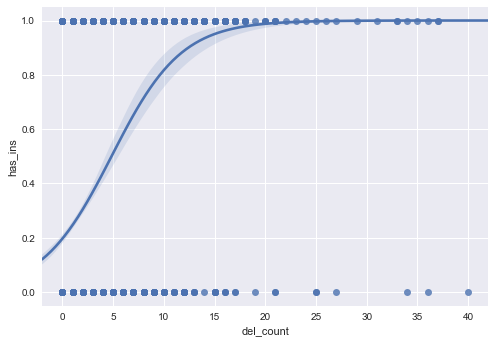

In [65]:
sb.regplot(x='del_count', y='has_ins', data=data, logistic=True)

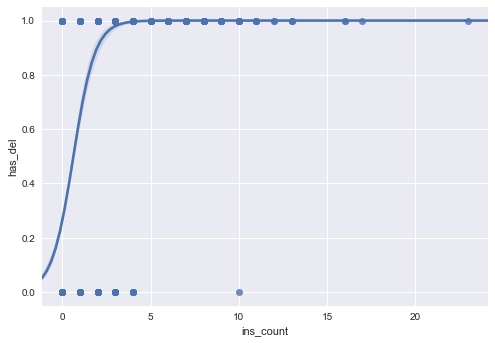

In [66]:
sb.regplot(x='ins_count', y='has_del', data=data, logistic=True)

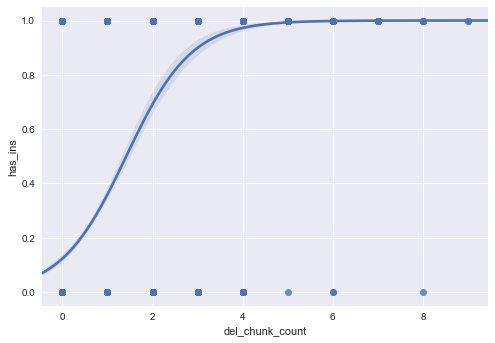

In [67]:
sb.regplot(x='del_chunk_count', y='has_ins', data=data, logistic=True)